In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, f1_score, confusion_matrix, mean_squared_error
from sklearn import metrics

import keras
from keras.layers import Dense , LSTM, Dropout, Activation
from keras.models import Sequential, load_model

In [ ]:
path = ('/content/drive/MyDrive/KHDL_TH/PM_train.txt')
df = pd.read_csv(path, delimiter = ' ', header = None)
df.head()

In [ ]:
df = df.drop([26,27],axis = 1) # drop vi 2 cot nay la gia tri null
col_names = ['id','cycle','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
# update lại tên cột vì data chưa có tên cột
df.columns = col_names
df.head()

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
#['cycle','setting1','setting2','s2','s3','s4','s7','s8','s11','s12','s13','s14','s15','','s17',,'s20','s21']

In [ ]:
# tất cả các trưng đều ở dg numeric và không có trường nào chứa missing data

In [ ]:
df['id'].unique()

In [ ]:
df.groupby('id')['cycle'].transform('last')- df['cycle']

In [ ]:
df['TTF'] = df.groupby('id')['cycle'].transform('last')- df['cycle']  # với mỗi id ta lấy giá trị cuối cùng của cycle , và trừ đi cycle thì ta được TTF
df['label1'] = df['TTF'].apply(lambda x: 0 if x > 30 else 1)        # nếu TTF <30 thì label1 là 1 , nếu TTF >30 thì label1 là 0
df['label2'] = df['TTF'].apply(lambda x: 0 if x > 30 else 1 if x>15 else 2) # tương tu với label1 thì label chia ra thành 3 , nếu <15 thì label sẽ là 2
df.head()

In [ ]:
# thống kê về số lượng trong các label

In [ ]:
df['label1'].value_counts()

In [ ]:
df['label2'].value_counts()

In [ ]:
# thống kê một số trường số

In [ ]:
df.describe()

In [ ]:
df.columns[2:-3]

In [ ]:
mms = MinMaxScaler()  # chuẩn hóa dữ liệu về khoảng 0-1 : vì các giá trị đều lớn ?????????????
df1 = df.copy()
for col in df1.columns[2:-3]:
  df1[col] = mms.fit_transform(df1[[col]])
df1[['cycle_norm']] = mms.fit_transform(df1[['cycle']])
df1.head()

In [ ]:
df.columns[5:-3]

In [ ]:
fig, ax = plt.subplots(nrows = 7, ncols = 3, figsize = (25, 25))
id_10 = np.random.choice(df['id'], 10)
for i ,s_name in enumerate(df.columns[5:-3]):
  r = i//3
  c = i%3
  for id in id_10:
    test = df[df['id'] == id]
    ax[r][c].plot(test['cycle'], test[s_name], label = f'Engine {id}')
    ax[r][c].set(title = s_name)
plt.legend()
plt.show()

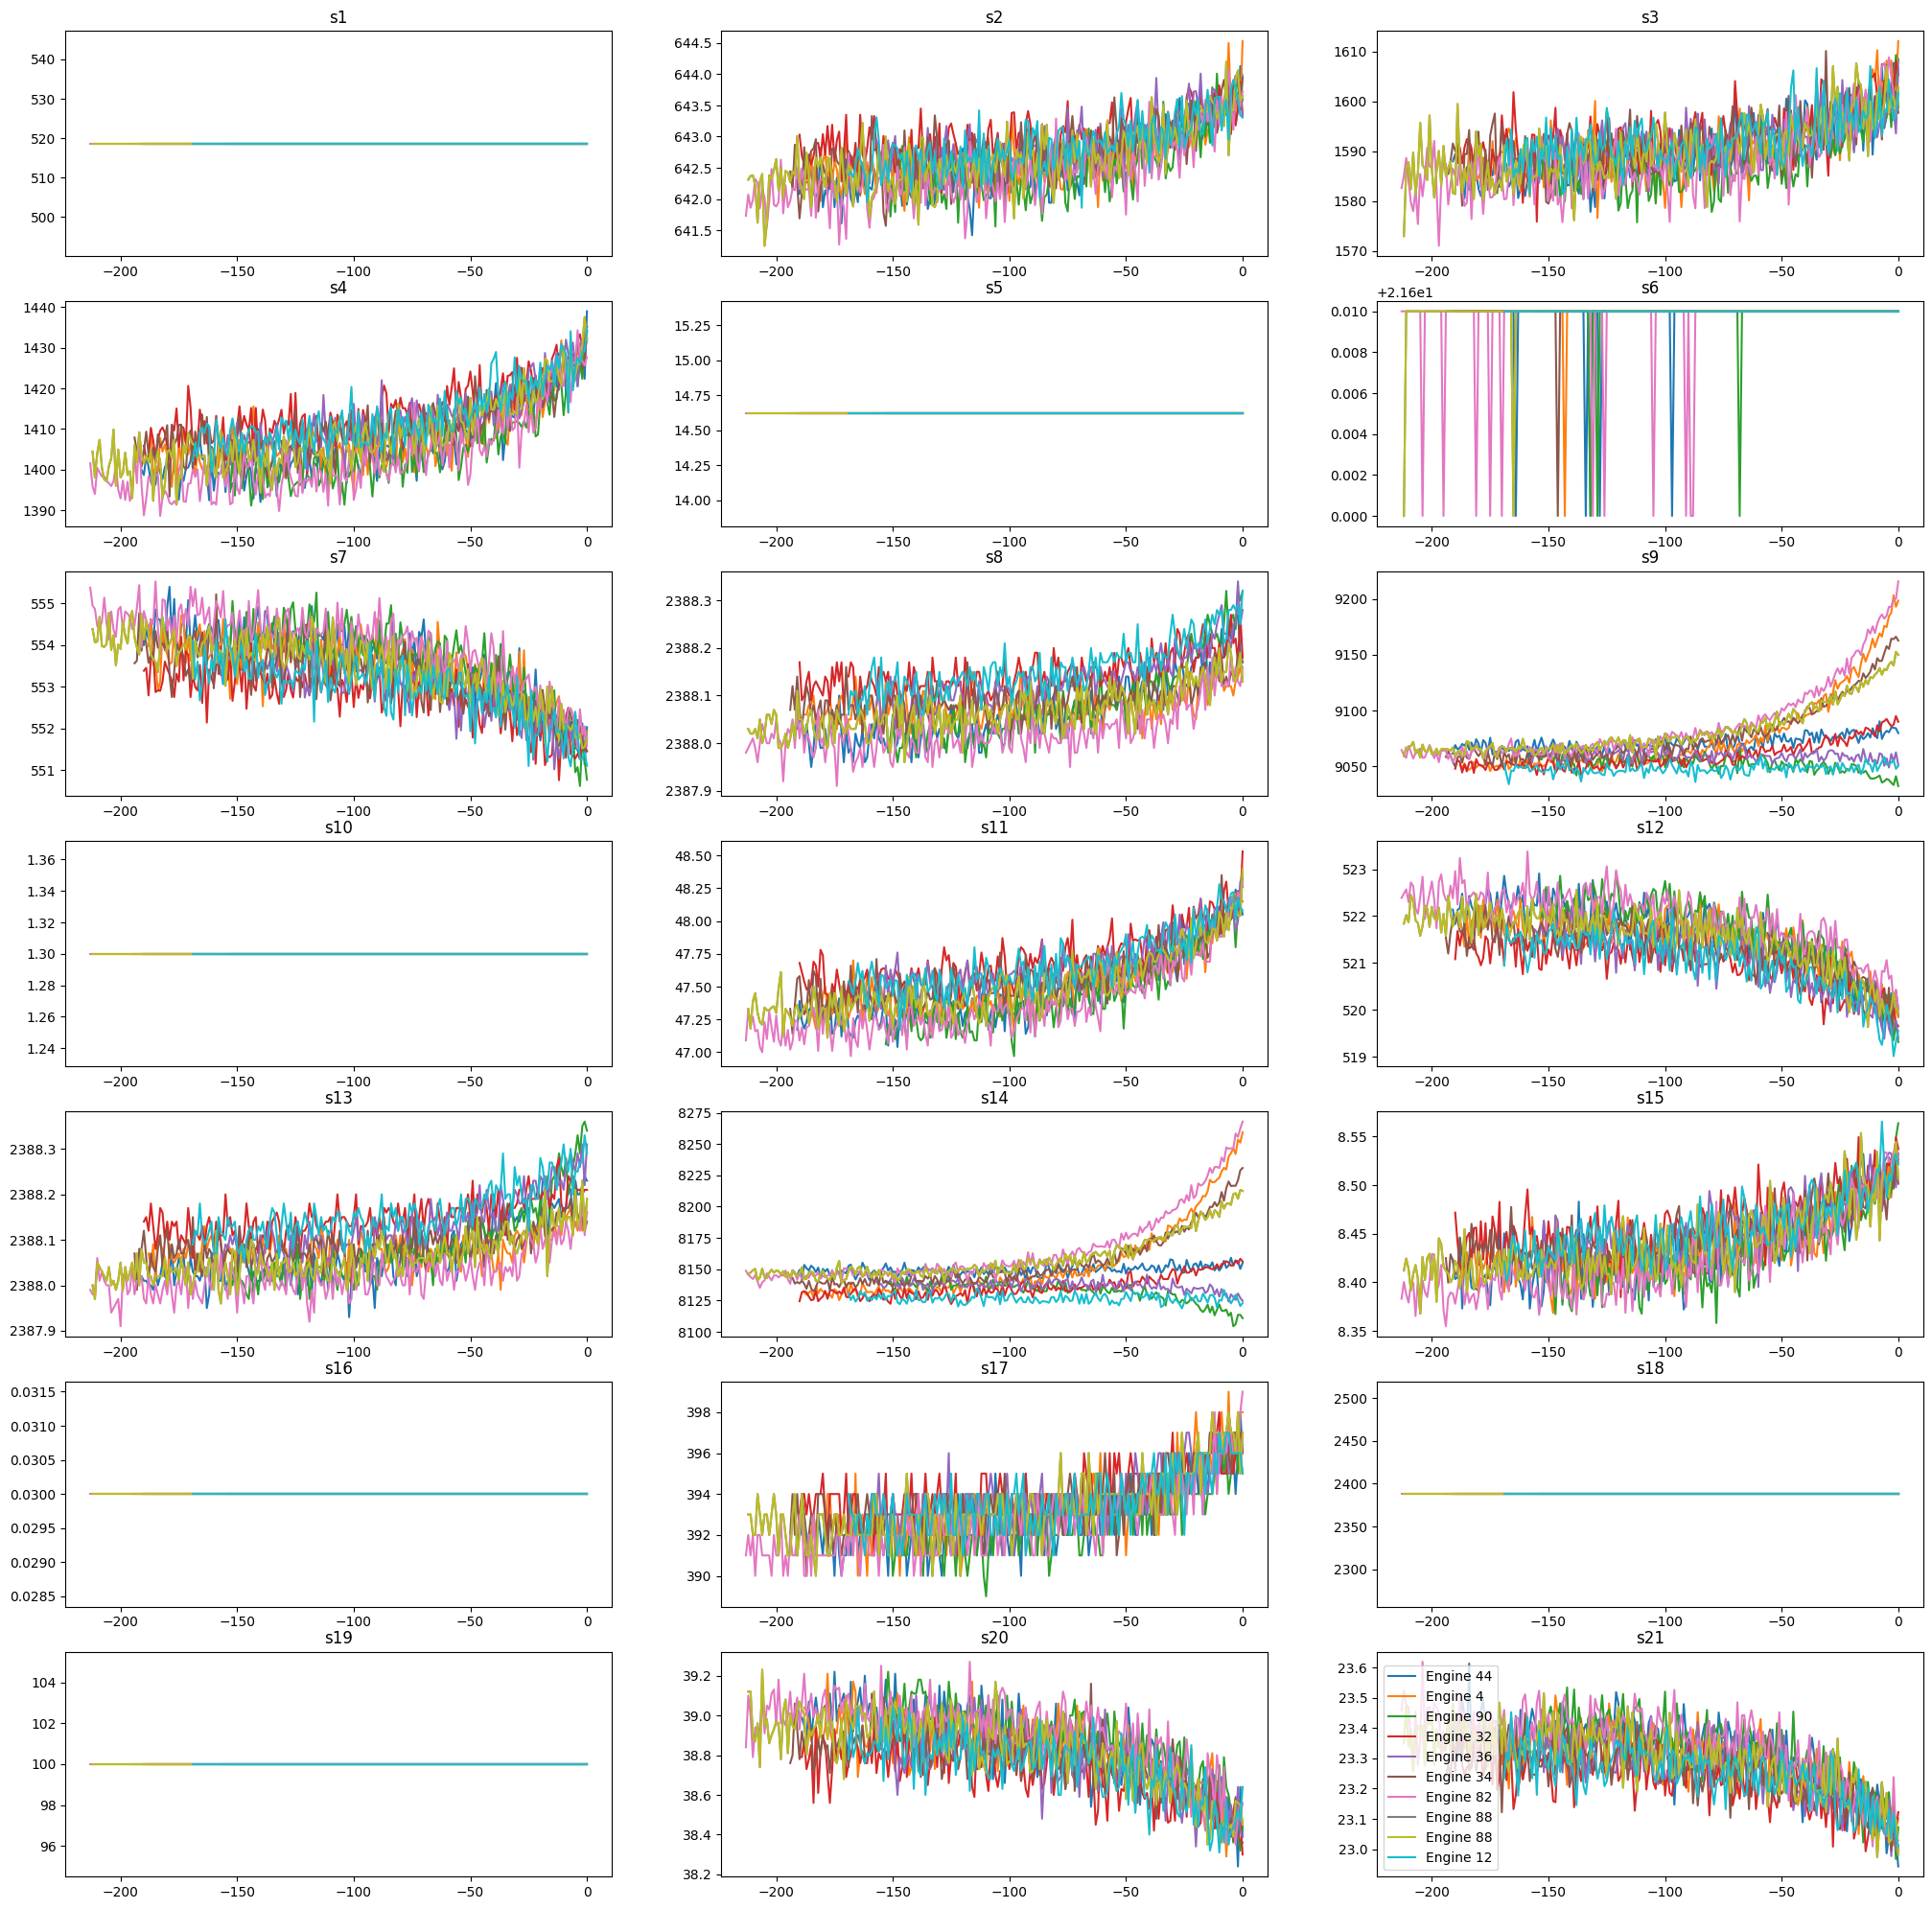

In [ ]:
fig, ax = plt.subplots(nrows = 7, ncols = 3, figsize = (25, 25))
id_10 = np.random.choice(df['id'], 10)
for i ,s_name in enumerate(df.columns[5:-3]):
  r = i//3
  c = i%3
  for id in id_10:
    test = df[df['id'] == id]
    ax[r][c].plot(test['TTF']*(-1), test[s_name], label = f'Engine {id}')
    ax[r][c].set(title = s_name)
plt.legend()
plt.show()

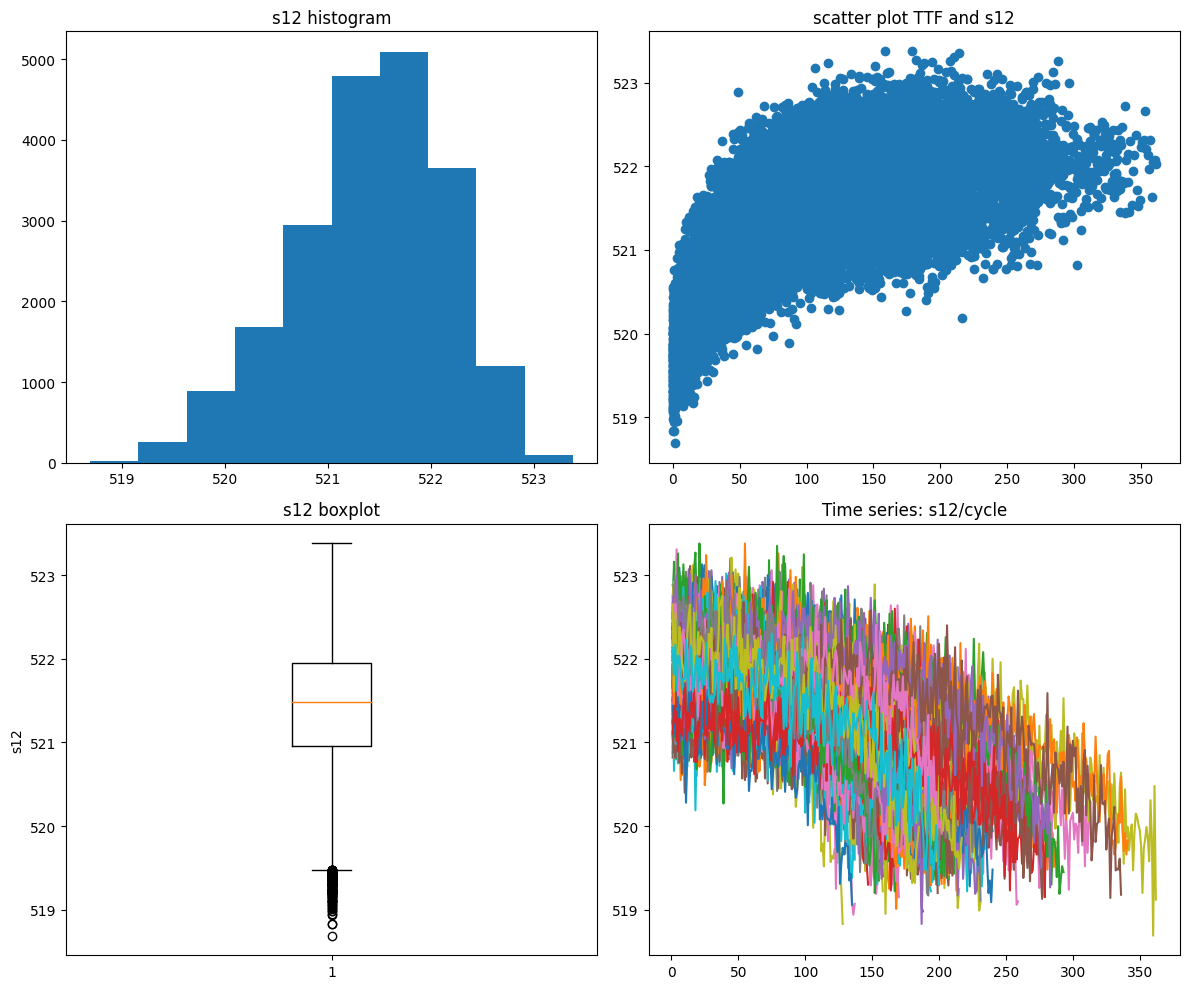

In [ ]:
def plot_t(df, name):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

    ax[0][0].hist(df[name]) # vẽ biểu đồ histogram cho sensor 'name' trong data df

    ax[0][0].set_title(f'{name} histogram')

    ax[0][1].scatter(df['TTF'], df[name] ) # tương tự với TTF và sensor 'name'
    ax[0][1].set_title(f'scatter plot TTF and {name}')

    ax[1][0].boxplot(df[name])  # boxplot cho 'name'
    ax[1][0].set_ylabel(name)
    ax[1][0].set_title(f'{name} boxplot')

    ax[1][1].set_title(f'Time series: {name}/cycle')
    for engine_id in df['id'].unique():
        engine_data = df[df['id'] == engine_id]
        ax[1][1].plot(engine_data['cycle'], engine_data[name])
    plt.tight_layout()
    plt.show()

plot_t(df, 's12')


In [ ]:
l = ['setting1','setting2','setting3', 's1', 's5', 's10', 's16', 's18', 's19']
df.columns.difference(l)

Index(['TTF', 'cycle', 'id', 'label1', 'label2', 's11', 's12', 's13', 's14',
       's15', 's17', 's2', 's20', 's21', 's3', 's4', 's6', 's7', 's8', 's9'],
      dtype='object')

In [ ]:
#lst = ['cycle','setting1','setting2','s2', 's3','s4','s6', 's7', 's8', 's9', 's11', 's12', 's13', 's14','s15','s17', 's20', 's21', 'TTF']
lst = df.columns.difference(l)

In [ ]:
plt.figure(figsize = (15, 10))
mask = np.triu(np.ones_like(df[lst].corr(), dtype=np.bool))
sns.heatmap(df[lst].corr(), annot = True, fmt = '.1f',  cmap = 'vlag_r',mask = mask)

In [ ]:
# drop them cột s9 or s14. ngoài ra drop những cột chỉ chứa 1 giá trị như : setting3, s1, s5, ,s10,s16,s18,s19
# ngoài ra còn cột 'id' và 's6' có độ tương quan thấp

In [ ]:
df1 = df1.drop(columns = ['setting3', 's1', 's5','s6','s9', 's10', 's16', 's18', 's19'] , axis = 1)   #drop những cột chỉ có 1 giá trị và 's9' vì s9 gần như là đa cộng tuyến với 's14'
df1.head()

In [ ]:
path1 = ('/content/drive/MyDrive/KHDL_TH/PM_test.txt')
df_test = pd.read_csv(path1, delimiter = ' ', header = None)
df_test = df_test.drop([26,27],axis = 1)
df_test.columns = col_names    # tương tự như tập train , ta cũng đổi tên tương tự và drop 2 cột cuối vì 2 cột cuối đều là NaN

In [ ]:
df_test.head()

In [ ]:
path2 = '/content/drive/MyDrive/KHDL_TH/PM_truth.txt'
df_truth = pd.read_csv(path2, delimiter= ' ', header =None)
df_truth.head()

In [ ]:
df_truth = df_truth.drop([1], axis = 1)
df_truth.columns = ['cycle_remain']
df_truth['id'] = df_truth.index+1
# đổi tên và tạo cột 'id' cột 'id' = index của df_truth + 1

In [ ]:
df_truth.head()

In [ ]:
df_test = df_test.merge(df_truth, on = 'id', how = 'right')
# gộp 2 tập data lại với nhau vì ta cần tìm ra TTF còn lại 'thực sự'

In [ ]:
df_test.groupby('id')['cycle'].transform('last')

In [ ]:
df_test['TTF'] = df_test.groupby('id')['cycle'].transform('last') + df_test['cycle_remain']- df_test['cycle']   # TTF thực sự của mỗi 'id'
df_test.head()

In [ ]:
df_test['label1'] = df_test['TTF'].apply(lambda x: 0 if x > 30 else 1)
df_test['label2'] = df_test['TTF'].apply(lambda x: 0 if x > 30 else 1 if x>15 else 2)
df_test = df_test.drop('cycle_remain', axis = 1)    # sau khi có TTF thì thêm 2 cột label1 với label2 , sau khi đã có 2 cột rồi thì bỏ cột 'cycle_remain'
df_test.head()

In [ ]:
df_test.columns[2:26]

In [ ]:
mms1 = MinMaxScaler()   # chuẩn hóa lại dữ liệu cho bộ test
d_1 = df_test.copy()
for col in d_1.columns[2:26]:
  d_1[col] = mms1.fit_transform(d_1[[col]])
d_1[['cycle_norm']] = mms1.fit_transform(d_1[['cycle']])
d_1.head()

In [ ]:
d_1 = d_1.drop(columns = ['setting3', 's1', 's5','s6','s9', 's10', 's16', 's18', 's19'] , axis = 1)  # drop những cột mà data_train đã bỏ
d_1.head()

In [ ]:
df1.shape

In [ ]:
df1.head()

In [ ]:
d_1.head()

In [ ]:
X_train = df1.drop(['id', 'cycle','label1','label2','cycle_norm','TTF'],axis=1)
y_train = df1['label1']

In [ ]:
X_test = d_1.drop(['id','cycle','label1','label2','cycle_norm','TTF'],axis=1)
y_test = d_1['label1']

In [ ]:
X_train.head()

In [ ]:
X_test.head()

In [ ]:
y_train.value_counts()

In [ ]:
y_test.value_counts()

In [ ]:
model = LogisticRegression(class_weight = {0:1, 1:6})
model.fit(X_train,y_train)

In [ ]:
y_pred = model.predict(X_test)
y_score = model.score(X_test, y_test)

In [ ]:
y_score

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(model)
print(f"Accuracy: {accuracy}")
print(f"ROC-AUC: {roc_auc}")
#print(f"Recall: {recall}")
#print(f"Precision: {precision}")
#print(f"F1-Score: {f1}")
print(confusion_matrix(y_test,y_pred))

In [ ]:
y_pred_proba = model.predict_proba(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba[:,1])
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC of LogisticRegression')
plt.show()

In [ ]:
model1 = RandomForestClassifier(class_weight = {0:1, 1:6})
model1.fit(X_train,y_train)

y_pred1 = model1.predict(X_test)
roc_auc1 = roc_auc_score(y_test, y_pred1)
recall1 = recall_score(y_test, y_pred1)
precision1 = precision_score(y_test, y_pred1)
accuracy1 = accuracy_score(y_test, y_pred1)
f11 = f1_score(y_test, y_pred1)
print(model1)
print(f"Accuracy: {accuracy1}")
print(f"ROC-AUC: {roc_auc1}")
#print(f"Recall: {recall1}")
#print(f"Precision: {precision1}")
#print(f"F1-Score: {f11}")
print(confusion_matrix(y_test,y_pred1))

In [ ]:
y_pred_proba1 = model1.predict_proba(X_test)
fpr1, tpr1, _ = metrics.roc_curve(y_test, y_pred_proba1[:,1])
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.3f' % roc_auc1)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC of RandomForestClassifier')
plt.show()

In [ ]:
model2 = GaussianNB()
model2.fit(X_train,y_train)
y_pred2 = model2.predict(X_test)
roc_auc2 = roc_auc_score(y_test, y_pred2)
recall2 = recall_score(y_test, y_pred2)
precision2 = precision_score(y_test, y_pred2)
accuracy2 = accuracy_score(y_test, y_pred2)
f12 = f1_score(y_test, y_pred2)
print(model2)
print(f"Accuracy: {accuracy2}")
print(f"ROC-AUC: {roc_auc2}")
#print(f"Recall: {recall2}")
#print(f"Precision: {precision2}")
#print(f"F1-Score: {f12}")
print(confusion_matrix(y_test,y_pred2))

In [ ]:
y_pred_proba2 = model2.predict_proba(X_test)
fpr2, tpr2, _ = metrics.roc_curve(y_test, y_pred_proba2[:,1])
plt.plot(fpr2, tpr2, 'b', label = 'AUC = %0.2f' % roc_auc2)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC of GaussianNB')
plt.show()

In [ ]:
scale_pos_weight = 3100 / 17531
params = {
    'scale_pos_weight': scale_pos_weight,}
xg = XGBClassifier(**params)
xg.fit(X_train,y_train)

xg_test = xg.predict(X_test)
xg_roc_auc = roc_auc_score(y_test, xg_test)
xg_grecall = recall_score(y_test, xg_test)
xg_precision = precision_score(y_test, xg_test)
xg_accuracy = accuracy_score(y_test, xg_test)
xg_f1 = f1_score(y_test, xg_test)

print(xg)
print(f"Accuracy: {xg_accuracy}")
print(f"ROC-AUC: {xg_roc_auc}")
#print(f"Recall: {xg_grecall}")
#print(f"Precision: {xg_precision}")
#print(f"F1-Score: {xg_f1}")
print(confusion_matrix(y_test,xg_test))

In [ ]:
xg_proba = xg.predict_proba(X_test)
xg_fpr, xg_tpr, _ = metrics.roc_curve(y_test, xg_proba[:,1])
plt.plot(xg_fpr, xg_tpr, 'b', label = 'AUC = %0.2f' % xg_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC of XGBClassifier')
plt.show()

In [ ]:
import joblib
#loaded_xg_boost_model = joblib.load('/content/drive/MyDrive/KHDL_TH/xg_boost_label.pkl')

In [ ]:
#l =[0.6000000000000001, 0.4615384615384615, 0.4353312302839356, 0.4713061542456529, 0.3579742699612005, 0.6612903225806264, 0.2926829268299116, 0.34931506849314786, 0.6324200913242066, 0.32558139534921793, 0.18789069476692077, 0.33700862895494055, 0.125, 0.6181818181818173, 0.6760084925690037]
#loaded_xg_boost_model.predict([l])

In [ ]:
df1.head()

In [ ]:
d_1.head()

Lstm for label1

In [ ]:
# Chuẩn bị dữ liệu train cho mô hình lstm

In [ ]:
sq_length = 50
def prepare_data(id_in_df,sq_length ,sq_cols):
  df_matrix = id_in_df[sq_cols].values
  num_elms = df_matrix.shape[0]
  for start, stop in zip(range(0, num_elms - sq_length), range(sq_length, num_elms)):
    yield df_matrix[start: stop, :]

In [ ]:
df1.columns[2:-4]

In [ ]:
sq_cols = df1.columns[2:-4].tolist()
seq_gen = (list(prepare_data(df1[df1['id']==id], sq_length,sq_cols))
            for id in df1['id'].unique())
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

In [ ]:
seq_array.shape

In [ ]:
seq_array

In [ ]:
def prepare_data_labels(id_in_df,sq_length, label):
  df_matrix = id_in_df[label].values
  num_elms = df_matrix.shape[0]
  return df_matrix[sq_length:num_elms, :]

In [ ]:
label_gen = [prepare_data_labels(df1[df1['id']==id],sq_length, ['label1'])
            for id in df1['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
print(label_array.shape)
print(label_array)

In [ ]:
# tạo mô hình lstm

In [ ]:
lstm = Sequential()
lstm.add(LSTM(
             input_shape=(sq_length, seq_array.shape[2]),
             units=100,
             return_sequences=True))

In [ ]:
lstm.add(Dropout(0.2))
lstm.add(LSTM(
          units=50,
          return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=label_array.shape[1]))

In [ ]:
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm.summary())

In [ ]:
%%time
history = lstm.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1)

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g', label='Train loss')
plt.plot(epochs, val_loss, 'b', label='Valid loss')
plt.title('Train and Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, train_acc, 'g', label='Train accuracy')
plt.plot(epochs, val_acc, 'b', label='Valid accuracy')
plt.title('Train and Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
scores = lstm.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

In [ ]:
y_pred_probabilities = lstm.predict(seq_array, verbose=1, batch_size=200)
threshold = 0.015
y_pred = (y_pred_probabilities > threshold).astype(int)

In [ ]:
y_true = label_array
print('Confusion matrix')
cm = confusion_matrix(y_true, y_pred)
cm

In [ ]:
d_1['id'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

dùng trên tập test (d_1)

In [ ]:
# dùng mô hình lstm để test trong tập test d_1

In [ ]:
# chuẩn bị dữ liệu giống như tập train , điều kiện là mỗi id phải có tối thiểu 50 bản ghi
seq_array_test_last = [d_1[d_1['id']==id][sq_cols].values[-sq_length:]
                       for id in d_1['id'].unique() if len(d_1[d_1['id']==id]) >= sq_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 15)

In [ ]:
y_mask = [len(d_1[d_1['id']==id]) >= sq_length for id in d_1['id'].unique()]

In [ ]:
label_array_test_last = d_1.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [ ]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 15)
(93, 1)


In [ ]:
scores_test = lstm.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.2518 - accuracy: 0.9462 - 30ms/epoch - 10ms/step
Accurracy: 0.9462365508079529


In [ ]:
# dùng lstm để dự đoán
y_pred_test = lstm.predict(seq_array_test_last)
y_true_test = label_array_test_last

3/3 [==============================] - 0s 4ms/step


In [ ]:
l = (y_pred_test > threshold).astype(int)

In [ ]:
print('Confusion matrix') #\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, l)
cm

Confusion matrix


array([[51, 17],
       [ 0, 25]])

In [ ]:
#lstm.save('/content/drive/MyDrive/KHDL_TH/lstm_for_label.h5')            # lưu lại mô hình

In [ ]:
load_lstm_for_label = load_model('/content/drive/MyDrive/KHDL_TH/lstm_for_label.h5')  # load lại mô hình để sử dụng

In [ ]:
array_2d = [[0 for _ in range(15)] for _ in range(50)]
test1 = [0.31609195, 0.4698795 , 0.38042292, 0.36073598,
                    0.65539455, 0.24242425, 0.3690476 , 0.7761194 , 0.30882353,
                    0.14119104, 0.33358985, 0.33333334, 0.5503876 , 0.7130627 ,
                    0.13573407]


test2 =  [0.21609195, 0.31666666 , 0.28042292, 0.26073598,
 0.55539455, 0.14242425, 0.2690476 , 0.6761194 , 0.20882353,
 0.04119104, 0.23358985, 0.23333334, 0.4503876 , 0.6130627 ,
 0.03573407]
array_2d[-1] = test1
array_2d[-2]= test2
# tạo 1 tập để test lại mô hình : 1 list gồm 48 list giá trị 0 và 2 list như trên
load_lstm_for_label.predict([array_2d])

1/1 [==============================] - 1s 653ms/step


array([[0.19328609]], dtype=float32)

In [ ]:
load_lstm_for_label.predict(seq_array_test_last)

3/3 [==============================] - 0s 5ms/step


array([[ 6.0040665e-01],
       [ 2.4820016e-01],
       [ 2.0673892e-01],
       [-4.1248929e-04],
       [-2.7688637e-01],
       [ 2.5352180e-01],
       [-8.6381994e-02],
       [-3.0848604e-02],
       [ 3.0384159e-01],
       [-1.1981248e-01],
       [-5.9061263e-02],
       [-3.3547521e-01],
       [-2.6099607e-01],
       [ 4.9989435e-01],
       [ 6.1697233e-01],
       [-1.2035946e-01],
       [ 1.6755414e+00],
       [-3.7263978e-02],
       [-4.0348399e-01],
       [ 1.4595119e+00],
       [-2.9870752e-01],
       [-1.5450786e-01],
       [-5.2123135e-03],
       [-3.8813561e-02],
       [ 2.6463810e-01],
       [ 2.1051202e+00],
       [ 3.1736359e-01],
       [ 1.7309950e-01],
       [ 1.8573917e+00],
       [ 2.1151252e+00],
       [ 1.6559527e+00],
       [ 5.1981592e-01],
       [ 9.5192569e-01],
       [ 1.4132816e+00],
       [ 4.8722127e-01],
       [ 1.3350089e+00],
       [ 3.4813771e-01],
       [-1.5149160e-01],
       [ 4.9304354e-01],
       [ 8.9371073e-01],


Lstm for TTF

In [ ]:
# train lstm cho TTF , cũng tương tự như label nhưng chỗ label_gen thay vì là label1 thì ta dùng TTF

In [ ]:
df11 = df1.copy()

In [ ]:
df11

,id,cycle,setting1,setting2,s2,s3,s4,s7,s8,s11,...,s13,s14,s15,s17,s20,s21,TTF,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,0.726248,0.242424,0.369048,...,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191,0,0,0.000000
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,0.628019,0.212121,0.380952,...,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190,0,0,0.002770
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,0.710145,0.272727,0.250000,...,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189,0,0,0.005540
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,0.740741,0.318182,0.166667,...,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188,0,0,0.008310
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,0.668277,0.242424,0.255952,...,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187,0,0,0.011080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,0.477011,0.250000,0.686747,0.587312,0.782917,0.254428,0.439394,0.726190,...,0.558824,0.194344,0.656791,0.750000,0.271318,0.109500,4,1,2,0.540166
20627,100,197,0.408046,0.083333,0.701807,0.729453,0.866475,0.162641,0.500000,0.708333,...,0.500000,0.188668,0.727203,0.583333,0.124031,0.366197,3,1,2,0.542936
20628,100,198,0.522989,0.500000,0.665663,0.684979,0.775321,0.175523,0.515152,0.738095,...,0.529412,0.212148,0.922278,0.833333,0.232558,0.053991,2,1,2,0.545706
20629,100,199,0.436782,0.750000,0.608434,0.746021,0.747468,0.133655,0.530303,0.916667,...,0.514706,0.203065,0.823394,0.583333,0.116279,0.234466,1,1,2,0.548476


In [ ]:
sq_length1 = 50
sq_cols1 = df11.columns[2:-4].tolist()
seq_gen1 = (list(prepare_data(df11[df11['id']==id],sq_length1, sq_cols1))
            for id in df11['id'].unique())
seq_array1 = np.concatenate(list(seq_gen1)).astype(np.float32)

In [ ]:
label_gen1 = [prepare_data_labels(df11[df11['id']==id],sq_length1, ['TTF'])
            for id in df11['id'].unique()]

label_array1 = np.concatenate(label_gen1).astype(np.float32)
print(label_array1.shape)

(15631, 1)


In [ ]:
lstm1 = Sequential()
lstm1.add(LSTM(
             input_shape=(sq_length1, seq_array1.shape[2]),
             units=100,
             return_sequences=False))
lstm1.add(Dense(units=label_array1.shape[1]))

In [ ]:
lstm1.add(Activation("linear"))
lstm1.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae'])
print(lstm1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               46400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 46501 (181.64 KB)
Trainable params: 46501 (181.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
seq_array1.shape

(15631, 50, 15)

In [ ]:
history1 = lstm1.fit(seq_array1, label_array1, epochs=70, batch_size=200, validation_split=0.05, verbose=2)

Epoch 1/70
75/75 - 4s - loss: 8218.2021 - mae: 71.7394 - val_loss: 7302.9512 - val_mae: 66.9167 - 4s/epoch - 47ms/step
Epoch 2/70
75/75 - 0s - loss: 7002.0830 - mae: 64.7384 - val_loss: 6388.8760 - val_mae: 61.6823 - 481ms/epoch - 6ms/step
Epoch 3/70
75/75 - 0s - loss: 6145.6616 - mae: 59.9172 - val_loss: 5600.7402 - val_mae: 57.2434 - 476ms/epoch - 6ms/step
Epoch 4/70
75/75 - 0s - loss: 5408.4072 - mae: 55.8490 - val_loss: 4928.3540 - val_mae: 53.5384 - 480ms/epoch - 6ms/step
Epoch 5/70
75/75 - 1s - loss: 4779.6489 - mae: 52.4653 - val_loss: 4362.2021 - val_mae: 50.5175 - 504ms/epoch - 7ms/step
Epoch 6/70
75/75 - 0s - loss: 4265.4761 - mae: 49.8373 - val_loss: 3912.2234 - val_mae: 48.2279 - 477ms/epoch - 6ms/step
Epoch 7/70
75/75 - 1s - loss: 3860.4868 - mae: 47.8601 - val_loss: 3593.6592 - val_mae: 46.6826 - 553ms/epoch - 7ms/step
Epoch 8/70
75/75 - 0s - loss: 3677.1204 - mae: 46.9870 - val_loss: 3467.0554 - val_mae: 46.0910 - 459ms/epoch - 6ms/step
Epoch 9/70
75/75 - 0s - loss: 3410

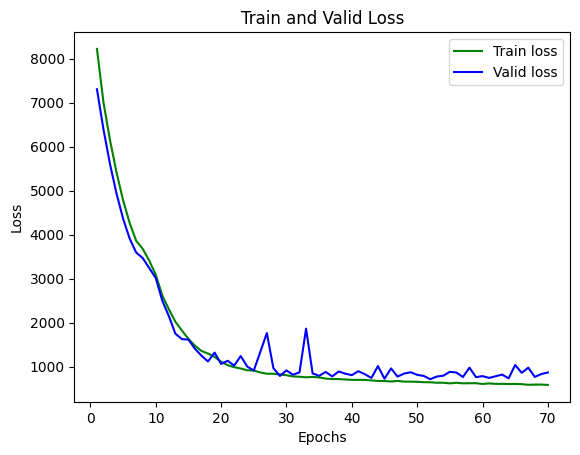

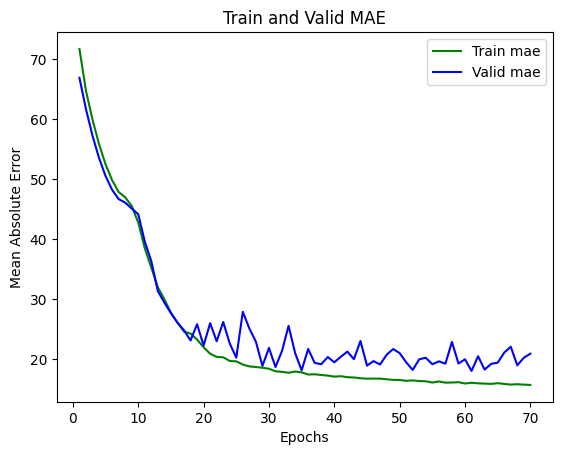

In [ ]:
import matplotlib.pyplot as plt

train_loss = history1.history['loss']
val_loss = history1.history['val_loss']
train_acc = history1.history['mae']
val_acc = history1.history['val_mae']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g', label='Train loss')
plt.plot(epochs, val_loss, 'b', label='Valid loss')
plt.title('Train and Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, train_acc, 'g', label='Train mae')
plt.plot(epochs, val_acc, 'b', label='Valid mae')
plt.title('Train and Valid MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [ ]:
np.sqrt(672.5193)

25.932977075530687

In [ ]:
# training metrics
scores1 = lstm1.evaluate(seq_array1, label_array1, verbose=1, batch_size=200)
print('Loss: {}'.format(scores1[0]))

79/79 [==============================] - 0s 4ms/step - loss: 705.9791 - mae: 17.5004
Loss: 705.9791259765625


In [ ]:
# dự đoán TTF
y_pred_probabilities1 = lstm1.predict(seq_array1, verbose=1, batch_size=200)

79/79 [==============================] - 1s 3ms/step


In [ ]:
y_true1 = label_array1

In [ ]:
len(y_pred_probabilities1)

15631

In [ ]:
len(y_true1)

15631

In [ ]:
df12 = d_1.copy()
#df12 = df12.loc[df12['label1']==1]

In [ ]:
df12

,id,cycle,setting1,setting2,s2,s3,s4,s7,s8,s11,...,s13,s14,s15,s17,s20,s21,TTF,label1,label2,cycle_norm
0,1,1,0.65625,0.692308,0.596215,0.421968,0.282214,0.608871,0.365854,0.273973,...,0.325581,0.152259,0.347076,0.375,0.500000,0.620099,142,0,0,0.000000
1,1,2,0.34375,0.230769,0.182965,0.504025,0.225240,0.800403,0.292683,0.479452,...,0.395349,0.277907,0.227709,0.500,0.645455,0.645718,141,0,0,0.003311
2,1,3,0.53125,0.538462,0.419558,0.464814,0.346130,0.651210,0.390244,0.479452,...,0.325581,0.192892,0.533557,0.500,0.700000,0.681104,140,0,0,0.006623
3,1,4,0.77500,0.461538,0.413249,0.391587,0.449867,0.643145,0.341463,0.328767,...,0.372093,0.217896,0.282359,0.250,0.627273,0.620382,139,0,0,0.009934
4,1,5,0.60000,0.461538,0.435331,0.471306,0.357974,0.661290,0.292683,0.349315,...,0.325581,0.187891,0.337009,0.125,0.618182,0.676008,138,0,0,0.013245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.81875,0.461538,0.665615,0.789665,0.641209,0.510081,0.317073,0.609589,...,0.255814,0.935703,0.664909,0.625,0.309091,0.370842,24,1,1,0.639073
13092,100,195,0.44375,0.384615,0.659306,0.692028,0.769042,0.471774,0.390244,0.547945,...,0.465116,0.914003,0.567593,0.750,0.236364,0.483652,23,1,1,0.642384
13093,100,196,0.47500,0.230769,0.728707,0.626071,0.458036,0.435484,0.536585,0.527397,...,0.348837,0.971066,0.594919,0.750,0.281818,0.381741,22,1,1,0.645695
13094,100,197,0.27500,0.538462,0.671924,0.673851,0.714111,0.502016,0.439024,0.554795,...,0.441860,1.000000,0.662991,0.750,0.318182,0.473461,21,1,1,0.649007


In [ ]:
sq_cols1

['setting1',
 'setting2',
 's2',
 's3',
 's4',
 's7',
 's8',
 's11',
 's12',
 's13',
 's14',
 's15',
 's17',
 's20',
 's21']

In [ ]:
seq_array_test_last1 = [df12[df12['id']==id][sq_cols1].values[-sq_length1:]
                       for id in df12['id'].unique() if len(df12[df12['id']==id]) >= sq_length1]

seq_array_test_last1 = np.asarray(seq_array_test_last1).astype(np.float32)
seq_array_test_last1.shape

(93, 50, 15)

In [ ]:
y_mask1 = [len(df12[df12['id']==id]) >= sq_length1 for id in df12['id'].unique()]
label_array_test_last1 = df12.groupby('id')['TTF'].nth(-1)[y_mask1].values
label_array_test_last1 = label_array_test_last1.reshape(label_array_test_last1.shape[0],1).astype(np.float32)
label_array_test_last1.shape

(93, 1)

In [ ]:
scores_test1 = lstm1.evaluate(seq_array_test_last1, label_array_test_last1, verbose=2)
print('Loss: {}'.format(scores_test1[0]))

3/3 - 0s - loss: 1098.0996 - mae: 27.2978 - 29ms/epoch - 10ms/step
Loss: 1098.099609375


In [ ]:
y_pred_test1 = lstm1.predict(seq_array_test_last1)
y_true_test1= label_array_test_last1

3/3 [==============================] - 0s 3ms/step


In [ ]:
y_pred_test1

array([[ 27.61169   ],
       [ 57.77843   ],
       [ 60.913     ],
       [ 81.75959   ],
       [ 78.38318   ],
       [ 51.64091   ],
       [ 89.59248   ],
       [ 63.410923  ],
       [ 49.907253  ],
       [ 63.997215  ],
       [ 55.432175  ],
       [134.79337   ],
       [ 76.40133   ],
       [ 38.328865  ],
       [ 13.709748  ],
       [ 57.589924  ],
       [ -3.0124714 ],
       [ 46.382458  ],
       [169.64258   ],
       [  4.3604035 ],
       [158.60944   ],
       [ 45.275463  ],
       [ 81.278534  ],
       [ 72.64598   ],
       [ 48.50996   ],
       [ -3.9556668 ],
       [ 28.704544  ],
       [ 63.505962  ],
       [ -4.9201717 ],
       [ -4.5759516 ],
       [ -1.9965522 ],
       [ 10.5562105 ],
       [ 17.391142  ],
       [  0.76039183],
       [  8.268974  ],
       [ -2.850752  ],
       [ 33.628082  ],
       [130.09213   ],
       [ 42.081326  ],
       [ 19.92289   ],
       [ 74.66297   ],
       [111.8747    ],
       [ -2.1580334 ],
       [ 66

In [ ]:
#lstm1.save('/content/drive/MyDrive/KHDL_TH/lstm_for_ttf.h5')

In [ ]:
load_lstm_ttf = load_model('/content/drive/MyDrive/KHDL_TH/lstm_for_ttf.h5')

In [ ]:
load_lstm_ttf.predict(seq_array_test_last1)

3/3 [==============================] - 0s 4ms/step


array([[ 23.324984 ],
       [ 51.044594 ],
       [ 59.36246  ],
       [ 82.11549  ],
       [ 87.10833  ],
       [ 53.15789  ],
       [ 92.921455 ],
       [ 56.25326  ],
       [ 45.646275 ],
       [ 59.955006 ],
       [ 53.185543 ],
       [125.946365 ],
       [ 84.349365 ],
       [ 39.419384 ],
       [ 14.778843 ],
       [ 53.514088 ],
       [ -3.0216665],
       [ 45.287197 ],
       [170.2714   ],
       [  5.3128247],
       [162.55724  ],
       [ 53.012722 ],
       [ 79.0826   ],
       [ 68.460686 ],
       [ 52.311073 ],
       [ -3.4051661],
       [ 30.2601   ],
       [ 62.332493 ],
       [ -4.6816316],
       [ -4.238659 ],
       [ -1.6353015],
       [ 11.022089 ],
       [ 16.727621 ],
       [  0.632934 ],
       [  9.23098  ],
       [ -2.8071814],
       [ 32.51384  ],
       [150.36127  ],
       [ 37.269135 ],
       [ 20.002096 ],
       [ 73.67459  ],
       [116.09948  ],
       [ -1.9336351],
       [ 62.33171  ],
       [ 65.42801  ],
       [ 1

In [ ]:
mean_squared_error(y_true_test1, y_pred_test1)

1098.0995

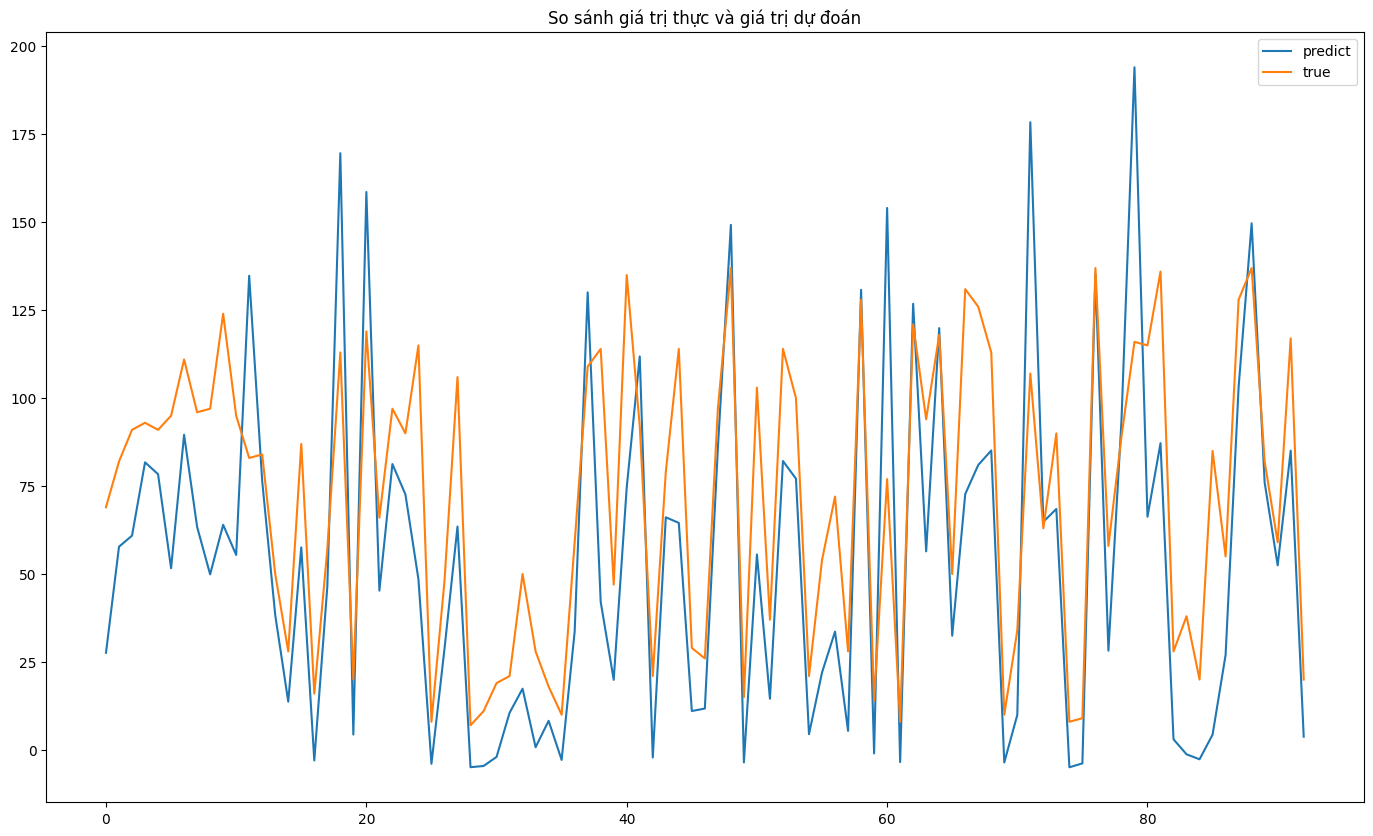

In [ ]:
plt.figure(figsize = (17,10))
plt.plot(y_pred_test1, label = 'predict')
plt.plot(y_true_test1, label = 'true')
plt.title('So sánh giá trị thực và giá trị dự đoán')
plt.legend()
plt.show()

In [ ]:
test_arr = y_true_test1 - y_pred_test1

(array([ 2.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  1.,  0.,  2.,  0.,  1.,  3.,  1.,  1.,
         3.,  3., 12.,  8.,  6.,  9.,  5.,  6.,  6.,  0.,  3.,  3.,  2.,
         4.,  1.,  0.,  1.,  2.,  0.,  1.,  0.,  1.,  0.,  1.]),
 array([-78.0745697 , -74.8999176 , -71.7252655 , -68.5506134 ,
        -65.3759613 , -62.20130539, -59.02665329, -55.85200119,
        -52.67734528, -49.50269318, -46.32804108, -43.15338898,
        -39.97873688, -36.80408096, -33.62942886, -30.45477676,
        -27.28012466, -24.10547066, -20.93081856, -17.75616455,
        -14.58151245, -11.4068594 ,  -8.23220634,  -5.05755377,
         -1.88290095,   1.29175186,   4.46640491,   7.64105749,
         10.81571007,  13.99036312,  17.16501617,  20.33966827,
         23.51432228,  26.68897438,  29.86362839,  33.03828049,
         36.21293259,  39.38758469,  42.5622406 ,  45.7368927 ,
         48.9115448 ,  52.0861969 ,  55.260849  ,  58.43550491,
         61.

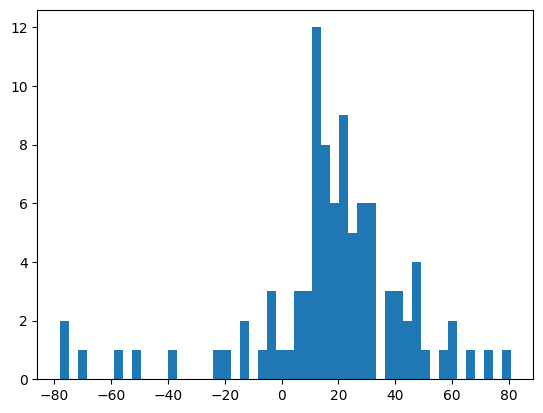

In [ ]:
plt.hist(test_arr, bins = 50)

In [ ]:
|